### VAG Inensity

Aim is to use the loading intensity method to obtain intensity values over 50Hz frequency bands
The problem is that it is a multiplication of acceleration and frequency so low accelerations at high frequency result in high numbers
but it could provide discrimination none the less

In [2]:
## VAG Intensity

from __future__ import division
import pandas as pd
import numpy as np
from scipy.signal import medfilt, butter, filtfilt, lfilter, find_peaks, find_peaks_cwt,resample, detrend
# wwelches test
from scipy.signal import welch, spectrogram, get_window
import urllib.parse
import logging
import math
import time
import statistics as stats
import json
from datetime import datetime, timedelta
import os, sys
import matplotlib.pyplot as plt

## required functions

# pass in 3 axis as a []
def vector_magnitude(vectors):
    n = len(vectors[0])
    assert all(len(v) == n for v in vectors), "Vectors have different lengths"
    vm = np.sqrt(sum(v ** 2 for v in vectors))
    return vm

def build_filter(frequency, sample_rate, filter_type, filter_order):
    #nyq = 0.5 * sample_rate
    if filter_type == "bandpass":
        #nyq_cutoff = (frequency[0] / nyq, frequency[1] / nyq)
        b, a = butter(filter_order, (frequency[0], frequency[1]), btype=filter_type, analog=False, output='ba', fs=sample_rate)
    elif filter_type == "low":
        #nyq_cutoff = frequency[1] / nyq
        b, a = butter(filter_order, frequency[1] / ny, btype=filter_type, analog=False, output='ba', fs=sample_rate)
    elif filter_type == "high":
        #nyq_cutoff = frequency[0] / nyq
        b, a = butter(filter_order, frequency[0], btype=filter_type, analog=False, output='ba', fs=sample_rate)
    else:
        nyq_cutoff = frequency / nyq
    return b, a
                 
def filter_signal(b, a, signal, filter):
    if(filter=="lfilter"):
        return lfilter(b, a, signal)
    elif(filter=="filtfilt"):
        return filtfilt(b, a, signal)
    elif(filter=="sos"):
        return sosfiltfilt(sos, signal)
    
def compute_fft_mag(data):
    fftpoints = int(math.pow(2, math.ceil(math.log2(len(data)))))
    fft = np.fft.fft(data, n=fftpoints)
    mag = np.abs(fft) / (fftpoints/2)
    return mag

# assumes a numpy arrray
def compute_power_spectrum(fft_mag):
    power = np.square(fft_mag)
    return power

def fft_graph_values(data, sample_rate):
    T = 1/sample_rate
    N_r =len(data)//2
    x = np.linspace(0.0, 1.0/(2.0*T), len(data)//2).tolist()
    y = data[:N_r]
    return [x,y]

In [31]:
#filter parameters
low_cut_off = 10
high_cut_off = -1
filter_order = 5   # 9th order has been used in literature?
filter_type =  "high"  #"bandpass"
sampling_rate = 2000

In [32]:
## dummy signal
duration = 5  # Duration in seconds
# Generate time vector
t = np.arange(0, duration, 1.0 / sampling_rate)
freq0 = 50   # frequency to filter out 
freq1 = 225  # Frequency of the first sine wave (Hz)
freq2 = 450  # Frequency of the second sine wave (Hz)
freq3 = 125

# Generate the signal
signal = np.sin(2 * np.pi * freq3 * t) + np.sin(2 * np.pi * freq0 * t) + np.sin(2 * np.pi * freq1 * t) + np.sin(2 * np.pi * freq2 * t) + 0.5 * np.random.randn(len(t))

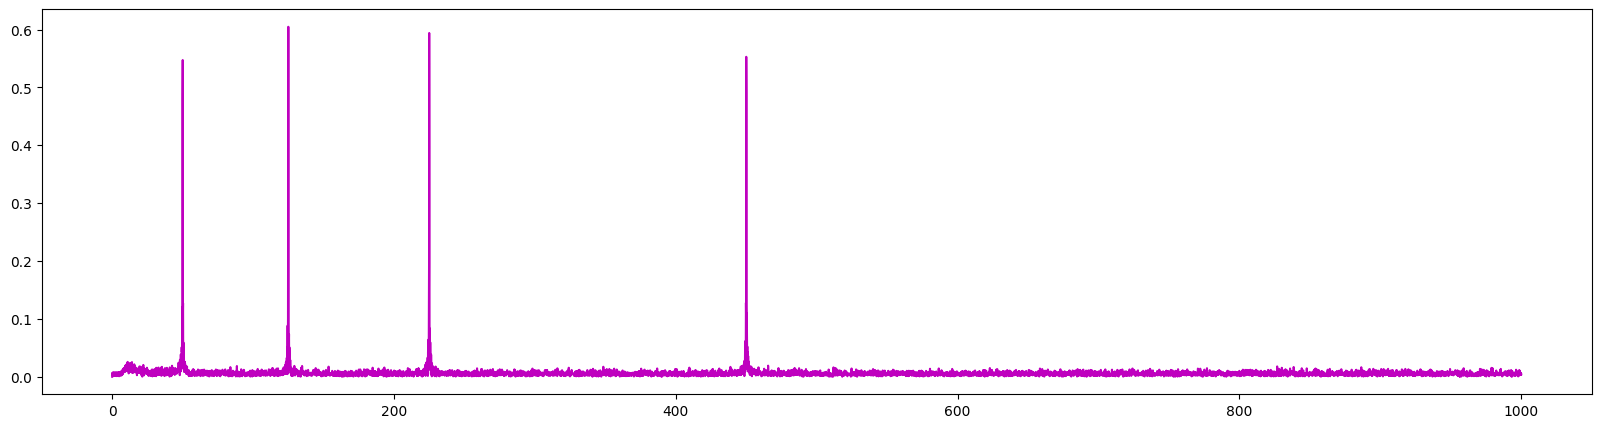

In [42]:
# creates 50 hz bands low and high are essentially the cutoff frequencies
f_bands = [(f, f + 50) for f in range(100, 1000, 50)] 

b,a = build_filter((low_cut_off, high_cut_off), sampling_rate, filter_type, filter_order)
f_signal = filter_signal(b,a, signal, "filtfilt")

# subtract the mean
f_signal = f_signal - np.mean(f_signal)

# compute the fft for the signal
f_mag = compute_fft_mag(f_signal)
fft_graph = fft_graph_values(f_mag, sampling_rate)


fig, ax = plt.subplots(1,1, figsize=(20, 5))

# add plots
ax.plot(fft_graph[0], fft_graph[1],color="m")

In [43]:
# Define the band limits
low = 600
high = 650

fft_freq = np.array(fft_graph[0])


# Create a mask for frequencies within the band
mask = (fft_freq >= low) & (fft_freq < high)

# Apply the mask to get filtered frequencies and magnitudes
f_freqs = fft_freq[mask]
f_mags = fft_graph[1][mask]
print(len(f_mags), len(f_freqs), max(f_mags))
# Compute the band intensity as the sum of frequencies * magnitudes
band_intensity = np.sum(f_freqs * f_mags)
print(band_intensity)

410 410 0.01505521460054881
1364.8847344322203
